,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
dG_unfold,dG_unfold,11.122981,0.830908,9.447296,12.798666,5.0,False,-inf,inf,NaN,NaN
m_unfold,m_unfold,-3.931975,0.290706,-4.518240,-3.345710,-2.0,False,-inf,inf,NaN,NaN
b_native,b_native,1.498278,0.014128,1.469786,1.526770,1.0,False,-inf,inf,NaN,NaN
m_native,m_native,-0.147143,0.010991,-0.169307,-0.124978,0.0,False,-inf,inf,NaN,NaN
b_denat,b_denat,0.107441,0.022891,0.061278,0.153604,0.0,False,-inf,inf,NaN,NaN
m_denat,m_denat,-0.031559,0.003886,-0.039395,-0.023723,0.0,False,-inf,inf,NaN,NaN


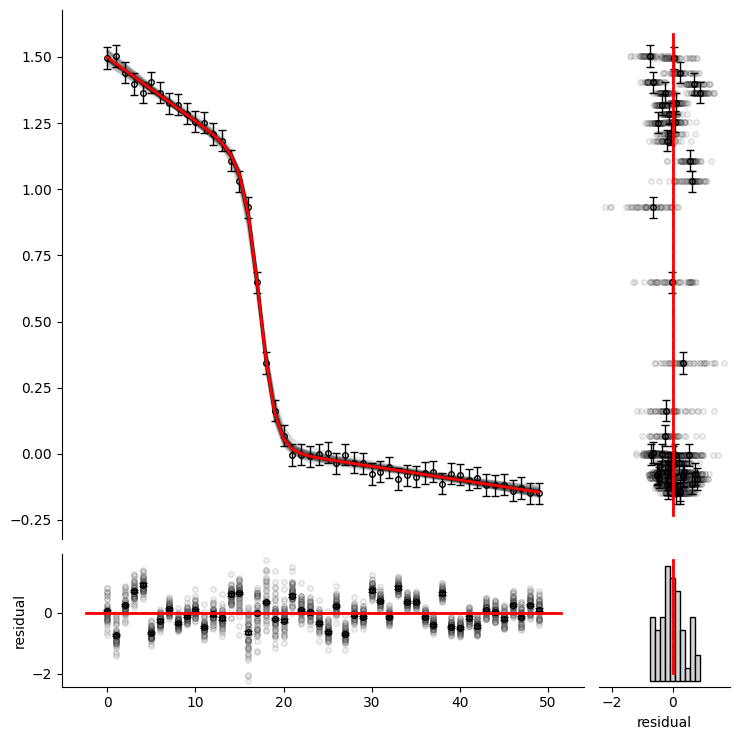

In [3]:
%matplotlib inline
import dataprob
import numpy as np

# ------------------------------------------------------------------------
# Define model and generate data

def linear_extrapolation(dG_unfold=5,m_unfold=-2,
                         b_native=1,m_native=0,
                         b_denat=0,m_denat=0,
                         osmolyte=None,T=298.15,R=0.001987):
    """
    Linear extrapolation unfolding model. 

    Parameters
    ----------
    dG_unfold : float, default=5
        unfolding free energy in water
    m_unfold : float, default=-2
        effect of osmoloyte on the folding energy
    b_native : float, default=1
        intercept of the native baseline
    m_native : float, defualt=0
        slope of the native baseline
    b_denat : float, default=0
        intercept of the denatured baseline
    m_denat : float, defualt=0
        slope of the denatured baseline
    osmolyte : numpy.ndarray
        array of osmolyte concentrations
    T : float, default=298.15
        temperature of experiment in K
    R : float, default=0.001987
        gas constant (default is kcal/mol)

    Returns
    -------
    signal : numpy.ndarray
        protein fraction folded signal as a function of osmolyte
    """
        
    RT = R*T
    dG = dG_unfold + m_unfold*osmolyte
    K = np.exp(-dG/RT)
    
    fx = 1/(1 + K)
    native_signal = (m_native*osmolyte + b_native)*fx
    denatured_signal = (m_denat*osmolyte + b_denat)*(1 - fx)

    return native_signal + denatured_signal
        
# Parameter for staphylococcal nuclease d+phs protein, pH 7.0
gen_params = {"dG_unfold":11.9,
              "m_unfold":-4.2,
              "b_native":1.5,
              "m_native":-0.15,
              "b_denat":0.1,
              "m_denat":-0.03}

# Generate data
T = 298
R = 0.001987
err = 0.020
num_points = 50
osmolyte = np.linspace(0,8,num_points)

y_obs_clean = linear_extrapolation(osmolyte=osmolyte,
                                   R=R,T=T,
                                   **gen_params)
y_obs = y_obs_clean + np.random.normal(0,err,num_points)
y_std = err*2

test_fcn = linear_extrapolation
non_fit_kwargs = {"osmolyte":osmolyte,
                  "R":R,
                  "T":T}

# ------------------------------------------------------------------------
# Run analysis

f = dataprob.setup(some_function=test_fcn,
                   method="ml",
                   non_fit_kwargs=non_fit_kwargs)


f.fit(y_obs=y_obs,
      y_std=y_std) 

fig = dataprob.plot_summary(f)
f.fit_df